In [1]:
#Shishir Khanal
#CMU-Optimal Controls from Jack Manchester
#Minimization: Merit Functions

In [2]:
import Pkg;
Pkg.activate(@__DIR__);
Pkg.instantiate();

Pkg.add("LinearAlgebra");
Pkg.add("PyPlot");
Pkg.add("ForwardDiff");

using LinearAlgebra;
using PyPlot;
using ForwardDiff;

  Activating project at `~/Documents/Optimal_Control/Sims/Optimization/Inequality_Constraints`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/Documents/Optimal_Control/Sims/Optimization/Inequality_Constraints/Project.toml`
  No Changes to `~/Documents/Optimal_Control/Sims/Optimization/Inequality_Constraints/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Documents/Optimal_Control/Sims/Optimization/Inequality_Constraints/Project.toml`
  No Changes to `~/Documents/Optimal_Control/Sims/Optimization/Inequality_Constraints/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Documents/Optimal_Control/Sims/Optimization/Inequality_Constraints/Project.toml`
  No Changes to `~/Documents/Optimal_Control/Sims/Optimization/Inequality_Constraints/Manifest.toml`


In [3]:
Q = Diagonal([0.5; 1])
#Quadratic Objective Function
function f(x)
    return 0.5*(x-[1; 0])'*Q*(x-[1; 0])
end

function ∇f(x)
    return Q*(x-[1; 0])
end

function ∇2f(x)
    return Q
end

∇2f (generic function with 1 method)

In [4]:
#Quadratic Constraint
function c(x)
    return x[1]^2 + 2*x[1] - x[2]
end

#Jacobian of Constraint
function δc(x)
    return [2*x[1]+2 -1]
end

δc (generic function with 1 method)

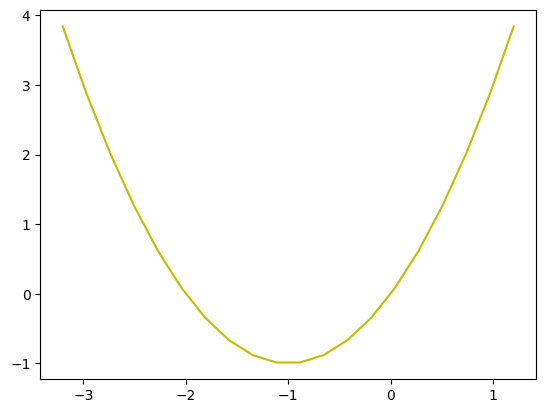

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f9baa082eb0>

In [5]:
function plot_landscape()
    Nsamp = 20
    Xsamp = kron(ones(Nsamp), LinRange(-4,4,Nsamp)')
    Ysamp = kron(ones(Nsamp)', LinRange(-4,4,Nsamp))
    Zsamp = zeros(Nsamp, Nsamp)
    for j = 1:Nsamp
        for k = 1:Nsamp
            Zsamp[j,k] = f([Xsamp[j,k]; Ysamp[j,k]])
        end
    end
    #positive definite hessian so level curve looks like a bowl
    #contour(Xsamp, Ysamp, Zsamp)
    
    xc = LinRange(-3.2, 1.2, Nsamp)
    #Quadratic Equality Constraint
    plot(xc, xc.^2+2.0.*xc, "y")
end

plot_landscape()

In [6]:
function gauss_newton_step(x,λ)
    H = ∇2f(x)
    C = δc(x)
    Δz = [H C'; C 0]\[-∇f(x)-C'*λ; -c(x)]
    Δx = Δz[1:2]
    Δλ = Δz[3]
    return Δx, Δλ
end

gauss_newton_step (generic function with 1 method)

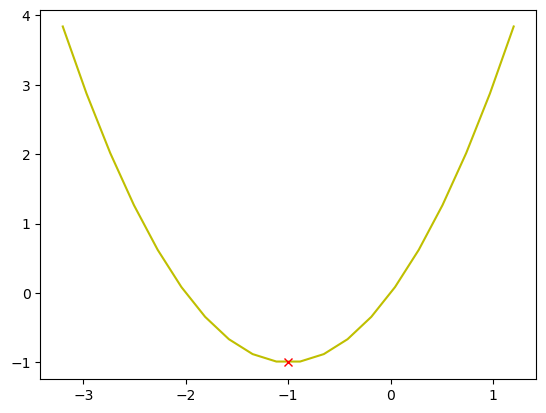

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f9ba8517220>

In [25]:
#Run again before running line search for reset
#Run again to after switch of merit function
xguess = [-1; -1]
λguess = [0.0]
plot_landscape()
plot(xguess[1], xguess[2], "rx")

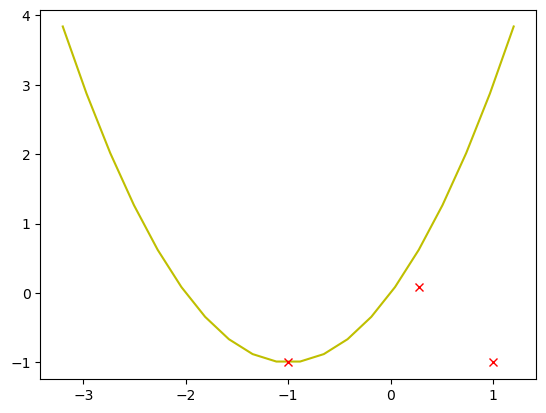

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f9bb43a77c0>

In [9]:
Δx, Δλ = gauss_newton_step(xguess[:,end], λguess[end])
xguess = [xguess xguess[:, end]+Δx]
λguess = [λguess λguess[end]+Δλ]
plot_landscape()
plot(xguess[1,:], xguess[2,:], "rx")
#Overshoots with gauss newton which is not preferred

In [10]:
#Fix with Line search
function P(x,λ)
    #First try with gradient of lagrangian and constraints stacked
    #KKT residual and trying to drive to 0
    ∇L = [-∇f(x)-δc(x)'*λ; -c(x)]
    return 0.5*dot(∇L, ∇L)
end

#This is as expensive to compute(gradient of Merit Function) as Newton step was
function ∇P(x,λ)
    H = ∇2f(x) + ForwardDiff.jacobian(xn -> δc(xn)'*λ,x)
    C =δc(x)
    return [H C'; C 0]*[-∇f(x)-C'*λ; -c(x)]
end

∇P (generic function with 1 method)

In [40]:
#Tuning parameter: How you care about minimizing objective vs. satisfying constraints
# When you change ρ from 1 to 10, you imply that you care about constraint violation alot
#the solution takes super tiny steps and backtracks alot so that it doesn't leave the constraint manifold
ρ = 1.0
function P(x,λ)
    f(x) + ρ*norm(c(x),1)
end

#this gradient is super cheap to compute
function ∇P(x,λ)
    [∇f(x) + ρ*δc(x)'*sign.(c(x)); zeros(length(λ))]
end

∇P (generic function with 1 method)

In [28]:
ρ = 1.0
#Also relatively cheap to compute gradients of for the Armeho rule
# Also a 
function P(x,λ)
    f(x) + λ'*c(x) + 0.5*ρ*dot(c(x),c(x))
end
function ∇P(x,λ)
    [∇f(x) + δc(x)'*(λ + ρ*c(x)); c(x)]
end

∇P (generic function with 1 method)

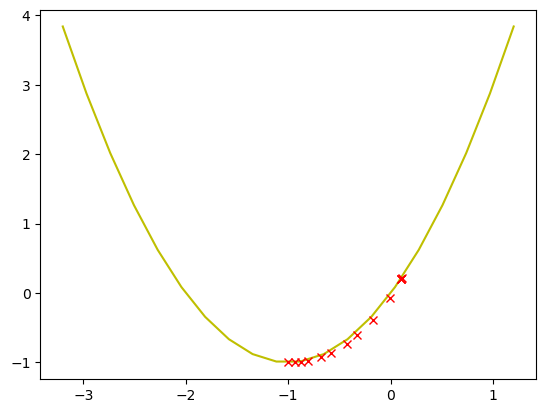

1

In [39]:
Δx, Δλ =gauss_newton_step(xguess[:,end], λguess[end])
α = 1
while P(xguess[:, end]+α*Δx, λguess[end]+α*Δλ) > P(xguess[:,end], λguess[end]) + 0.01*α*dot(∇P(xguess[:,end], λguess[end]), [Δx;Δλ])
    α = 0.5*α
end
xguess = [xguess xguess[:, end]+α*Δx]
λguess = [λguess λguess[end]+α*Δλ]
plot_landscape()
plot(xguess[1,:], xguess[2,:], "rx")
α
#The step is much shorter
#reach to answer with fewer iteration

In [28]:
function newton_step(x, λ)
    H = Δ2f(x) + ForwardDiff.jacobian(xn -> δc(xn)'*λ0, x)
    C = δc(x)
    Δz = [H C'; C 0]\[-∇f(x)-C'*λ; -c(x)]
    Δx = Δz[1:2]
    Δλ = Δz[3]
    return Δx, Δλ
end

newton_step (generic function with 1 method)

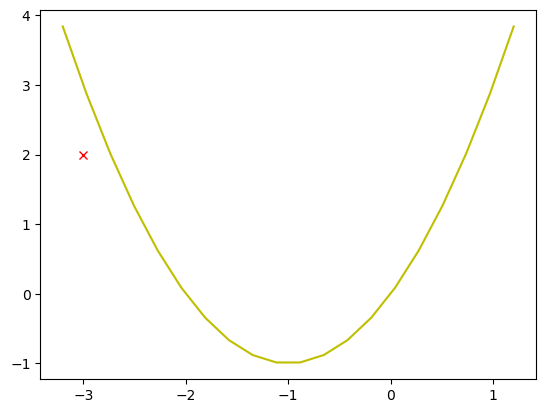

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f8dd5a44580>

In [32]:
xguess = [-3; 2]
λguess = [0.0]
plot_landscape()
plot(xguess[1], xguess[2], "rx")

In [42]:
H = ∇2f(xguess[:,end]) + ForwardDiff.jacobian(x -> δc(x)'*λguess[end], xguess[:,end])

2×2 Matrix{Float64}:
 0.910795  0.0
 0.0       1.0